In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install distance

     |████████████████████████████████| 180 kB 18.9 MB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=8762eb226d13789d9733c52d3fa5ad5e95bd13726f3c4027df2e304590b45f73
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [ ]:
df_train= pd.read_csv("train.csv" , nrows=20000)

print("(1). Noumber of data point in train.csv:", df_train.shape[0])

(1). Noumber of data point in train.csv: 20000


In [ ]:
#Checking whether there are any rows with null values
nan_rows= df_train[df_train.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
# let's fill the null value with ''
df_train= df_train.fillna('')
nan_rows= df_train[df_train.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
print("(1). Total number of questation pairs for training:- {}". format(len(df_train)))
print("(2). Questation pairs are not similar (is_duplicate= 0) in percentage:- {}%".format(100- round(df_train['is_duplicate'].mean()*100,2)))
print("(3). Questation pairs are similar (is_duplicate= 1) in percentage:- {}%".format(round(df_train['is_duplicate'].mean()*100,2)))

(1). Total number of questation pairs for training:- 20000
(2). Questation pairs are not similar (is_duplicate= 0) in percentage:- 62.63%
(3). Questation pairs are similar (is_duplicate= 1) in percentage:- 37.37%


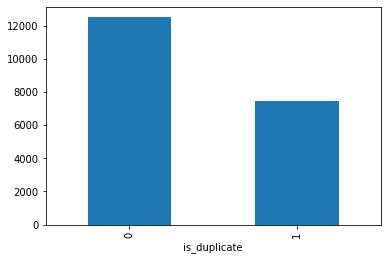

In [ ]:
df_train.groupby("is_duplicate")["id"].count().plot.bar()

In [ ]:
qids= pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
qs_uniq= len(np.unique(qids))
qs_morethan_onetime= np.sum(qids.value_counts()> 1)

print ("(1). Total number of  Unique Questions are:- {}".format(qs_uniq)) #print len(np.unique(qids))

print ("(2). Number of unique questions that appear more than one time:- {} ({}%)".format(qs_morethan_onetime,qs_morethan_onetime/qs_uniq*100))

print ("(3). Max number of times a single question is repeated:- {}".format(max(qids.value_counts()))) 
       
q_vals=qids.value_counts()

q_vals=q_vals.values

(1). Total number of  Unique Questions are:- 37767
(2). Number of unique questions that appear more than one time:- 1806 (4.781952498212726%)
(3). Max number of times a single question is repeated:- 7


In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df_train.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 7



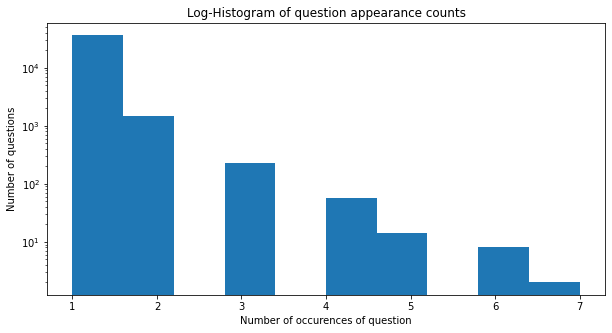

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(qids.value_counts())

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df_train.shape[0])

Number of duplicate questions 0


In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df_train = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df_train["freq_qid1"]= df_train.groupby("qid1")["qid1"].transform("count")
    df_train["freq_qid2"]= df_train.groupby("qid2")["qid2"].transform("count")

    df_train["q1len"]= df_train["question1"].str.len()
    df_train["q2len"]= df_train["question2"].str.len()

    df_train["q1_n_words"]= df_train["question1"].apply(lambda row: len(row.split(" ")))
    df_train["q2_n_words"]= df_train["question2"].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)
    df_train['word_Common'] = df_train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * (len(w1) + len(w2))
    df_train['word_Total'] = df_train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df_train['word_share'] = df_train.apply(normalized_word_share, axis=1)

    df_train['freq_q1+q2'] = df_train['freq_qid1']+df_train['freq_qid2']
    df_train['freq_q1-q2'] = abs(df_train['freq_qid1']-df_train['freq_qid2'])

    df_train.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
print ("Minimum length of the questions in question1 : " , min(df_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df_train[df_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df_train[df_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  2
Number of Questions with minimum length [question1] : 3
Number of Questions with minimum length [question2] : 0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



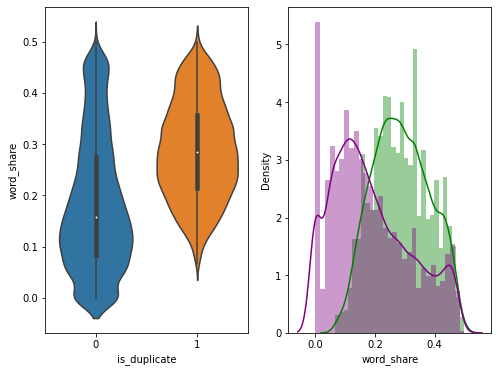

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train[0:])

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'purple' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



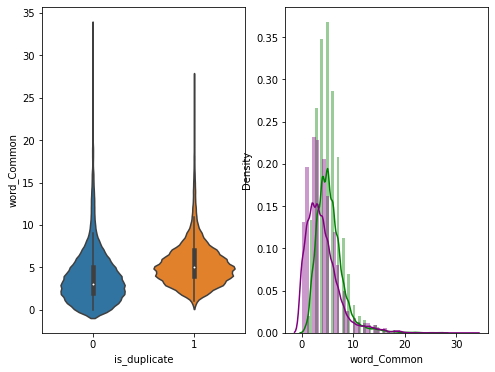

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df_train[0:])

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'purple' )
plt.show()

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    #Computing Fuzzy Features and Merging with Dataset
    
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv", nrows=20000)
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [ ]:
df_duplicate= df[df["is_duplicate"]== 1]
df_nonduplicate= df[df["is_duplicate"]== 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
positive= np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
negative= np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(positive))
print ("Number of data points in class 0 (non duplicate pairs) :",len(negative))

#Saving the np array OR all the text in positive and negative class into a text file which help us to plot word cloud
np.savetxt('train_positive.txt', positive, delimiter=' ', fmt='%s', encoding= "utf-8")
np.savetxt('train_negative.txt', negative, delimiter=' ', fmt='%s', encoding= "utf-8")

Number of data points in class 1 (duplicate pairs) : 14948
Number of data points in class 0 (non duplicate pairs) : 25052


In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textpositive_word = open(path.join(d, 'train_positive.txt'),encoding="utf-8").read()
textnegative_word = open(path.join(d, 'train_negative.txt'),encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textpositive_word))
print ("Total number of words in non duplicate pair questions :",len(textnegative_word))

Total number of words in duplicate pair questions : 802849
Total number of words in non duplicate pair questions : 1633208


Word Cloud for Duplicate Question pairs


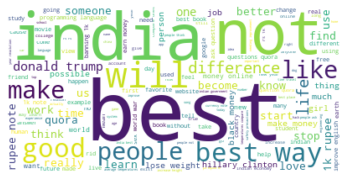

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textpositive_word), stopwords=stopwords)
wc.generate(textpositive_word)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


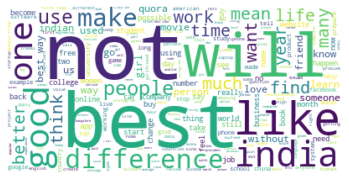

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textnegative_word),stopwords=stopwords)
# generate word cloud
wc.generate(textnegative_word)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

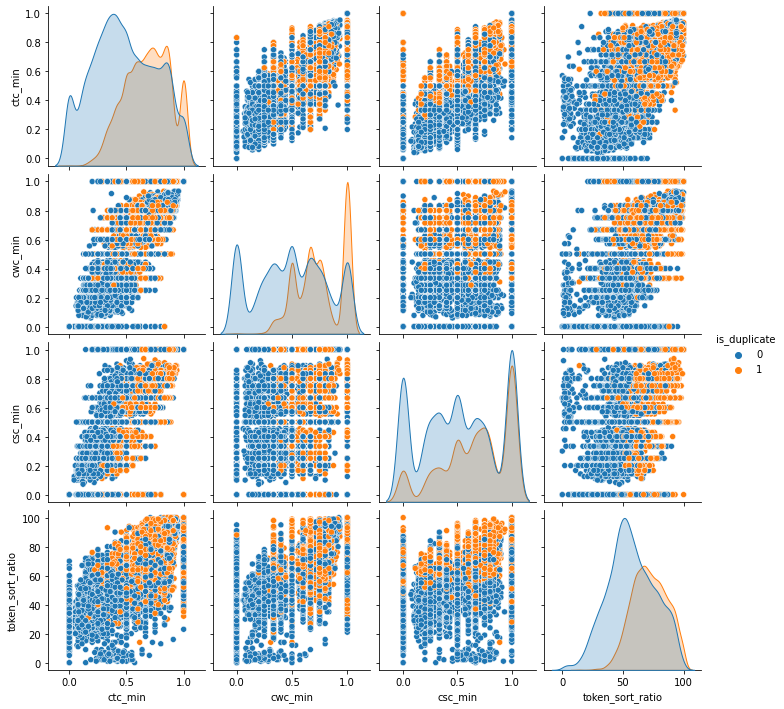

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



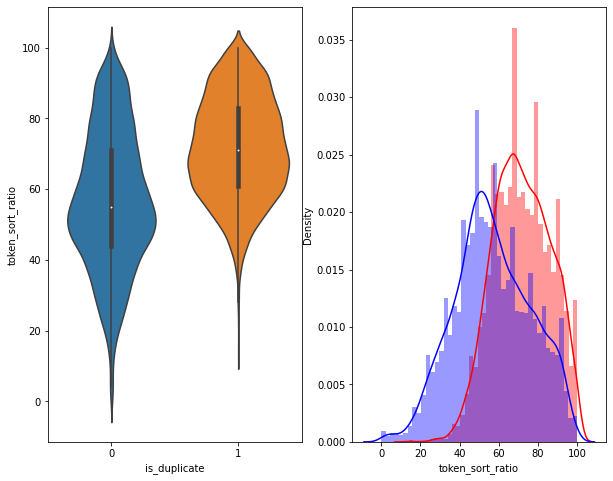

In [ ]:
# Distribution of the token_sort_ratio (Univariate analysis)
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



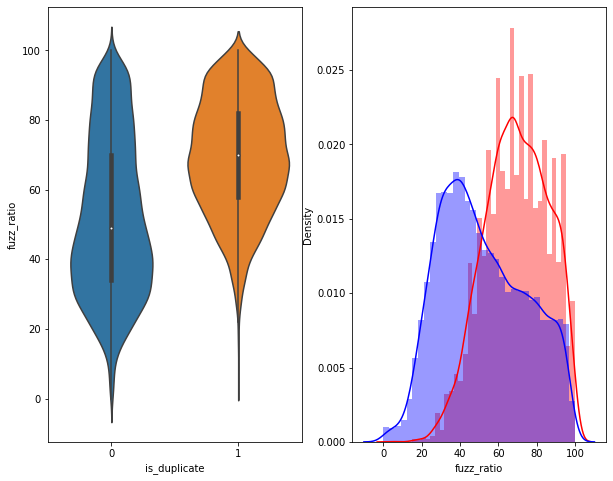

In [ ]:
# Distribution of the fuzz_ratio (Univariate analysis)
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention
# class sklearn.preprocessing.MinMaxScaler(): Transform features by scaling each feature to a given range.

from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df_subsampled['is_duplicate'].values

In [ ]:
tsne2d= TSNE(n_components=2,init='random', random_state=101,method='barnes_hut', n_iter=1000,verbose=2, angle=0.5).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.031s...
[t-SNE] Computed neighbors for 10000 samples in 1.809s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.107272
[t-SNE] Computed conditional probabilities in 1.051s
[t-SNE] Iteration 50: error = 96.0483398, gradient norm = 0.0215361 (50 iterations in 9.808s)
[t-SNE] It

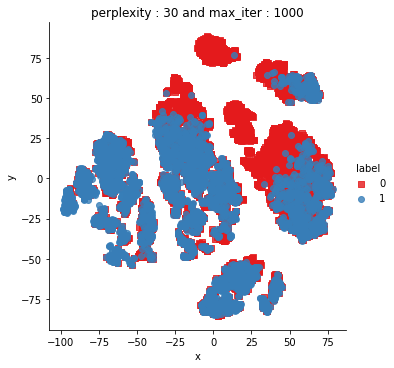

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=5,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
tsne3d= TSNE(n_components=3,init='random', random_state=101,method='barnes_hut', n_iter=1000,verbose=2, angle=0.5).fit_transform(X)

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
from tqdm import tqdm
import spacy

In [ ]:
# for avoid decoding problem
df= pd.read_csv("train.csv", nrows=20000)

# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [ ]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# tf-idf feature weights using sklearn.feature_extraction.text.TfidfVectorizer
# https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_)) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
# learn about TFIDF weighted Word2Vec : https://medium.com/@ranasinghiitkgp/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097
# en_vectors_web_lg, which includes over 1 million unique vectors.

#nlp = spacy.load('en_core_web_sm')

# Here I'm facing some error while i'm trying to call "en_core_web_sm" from spacy, so for that i directly copy the path and paste in load function.
nlp= spacy.load("en_core_web_sm")
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 20000/20000 [03:34<00:00, 93.07it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector)])     
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 20000/20000 [03:29<00:00, 95.42it/s]


In [ ]:
# loading 'nlp_features_train.csv' and 'df_fe_without_preprocessing_train.csv'

if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3 = df
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
df1.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [ ]:
# data before preprocessing 
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


In [ ]:
# Questions 1 tfidf weighted word2vec
df3_q1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-7.548885,38.486765,-67.580409,31.535364,142.342730,136.064867,17.438432,54.801613,81.543504,232.174689,...,-71.575028,-59.784288,-22.349227,102.100578,-68.41231,-54.985199,-67.932221,115.251354,59.491677,-12.142387
1,9.875156,-66.766795,-43.509140,69.964181,165.486118,89.950852,73.064984,43.477282,115.765513,106.430746,...,-31.032467,-79.124682,14.731149,-12.011067,-73.97292,66.981349,33.699732,118.501953,103.045948,6.076540


In [ ]:
# Questions 2 tfidf weighted word2vec
df3_q2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-16.045086,60.670618,-53.097714,18.937303,113.072113,102.522670,8.192982,66.406890,33.130013,210.069650,...,-72.004049,-36.772475,-31.463219,92.798202,-44.954326,-34.262362,-76.550827,98.394309,49.732174,-17.391566
1,1.351711,-9.139956,-120.110965,-6.817388,69.116376,13.924767,77.968786,76.051745,118.257004,257.160348,...,7.459751,-50.090381,-14.648498,6.454494,24.445747,151.464015,-58.298232,178.774593,108.167180,55.668486


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
#from mlxtend.classifier import StackingClassifier

from collections import Counter, defaultdict
from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")

In [ ]:
data= pd.read_csv("final_features.csv")
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,7.459751,-50.090381,-14.648498,6.454494,24.445747,151.464015,-58.298232,178.774593,108.16718,55.668486
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-25.212256,-17.848584,74.936357,26.745796,-88.248845,-176.447972,-89.937842,19.196938,19.03813,47.487317


In [ ]:
# after we read from file each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
# https://datascience.stackexchange.com/questions/62819/list-object-has-no-attribute-values-when-we-are-using-append-in-python
# Must read above link blog for converting list to int
y_true = list(map(int, y_true))

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (13999, 218)
Number of data points in test data : (6000, 218)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6262590185013215 Class 1:  0.37374098149867846
---------- Distribution of output variable in test data ----------
Class 0:  0.37366666666666665 Class 1:  0.37366666666666665


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("red")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8744282152167331


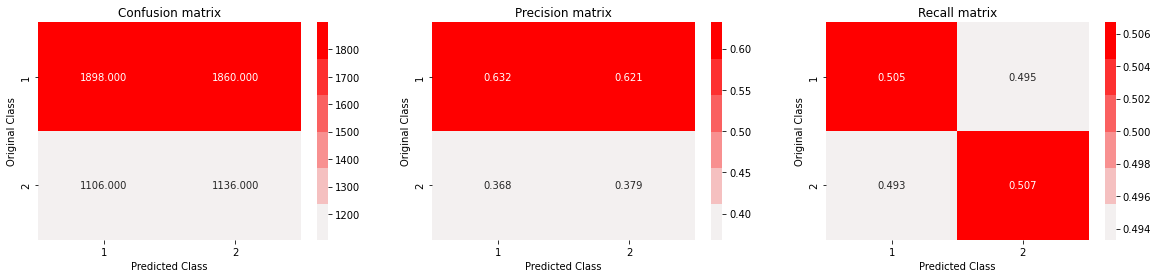

In [ ]:
from sklearn.metrics import log_loss
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6608784006913763
For values of alpha =  0.0001 The log loss is: 0.5636406168399805
For values of alpha =  0.001 The log loss is: 0.5654818497892128
For values of alpha =  0.01 The log loss is: 0.5552103210623541
For values of alpha =  0.1 The log loss is: 0.5509319911431716
For values of alpha =  1 The log loss is: 0.5487479010730147
For values of alpha =  10 The log loss is: 0.5546806970861886


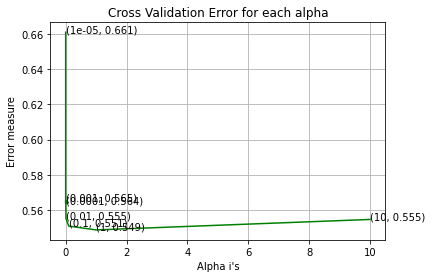

For values of best alpha =  1 The train log loss is: 0.5475193761444327
For values of best alpha =  1 The test log loss is: 0.5487479010730147
Total number of data points : 6000


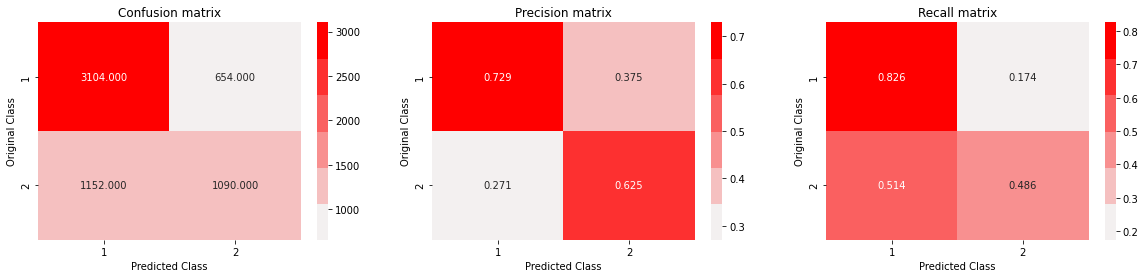

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6608784006913763
For values of alpha =  0.0001 The log loss is: 0.53410427987494
For values of alpha =  0.001 The log loss is: 0.5346730243994323
For values of alpha =  0.01 The log loss is: 0.5859768504836802
For values of alpha =  0.1 The log loss is: 0.6608784006913763
For values of alpha =  1 The log loss is: 0.6608784006913763
For values of alpha =  10 The log loss is: 0.6608784006913763


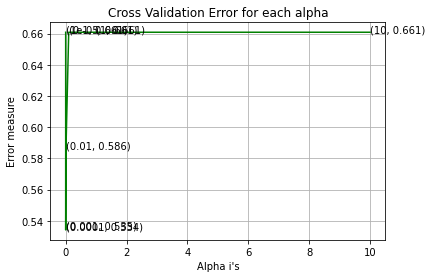

For values of best alpha =  0.0001 The train log loss is: 0.5339832991419783
For values of best alpha =  0.0001 The test log loss is: 0.53410427987494
Total number of data points : 6000


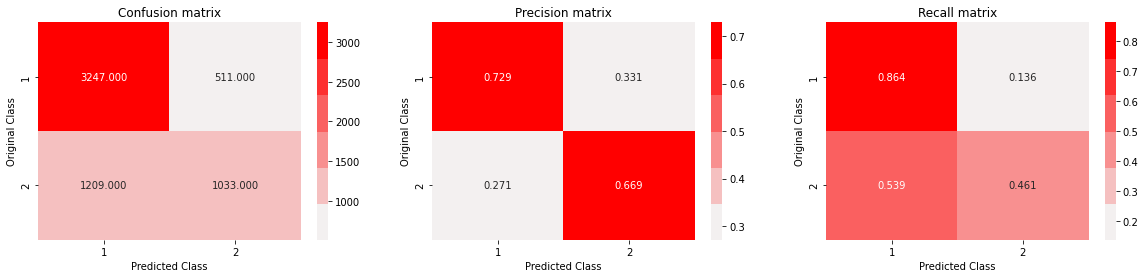

In [ ]:
# For ignoring ConvergenceWarning

#from sklearn.utils.testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning

#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore", category=ConvergenceWarning)


from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
    

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge',max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

[0]	train-logloss:0.686574	valid-logloss:0.686527
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.632764	valid-logloss:0.632325
[20]	train-logloss:0.593543	valid-logloss:0.593092
[30]	train-logloss:0.563245	valid-logloss:0.562877
[40]	train-logloss:0.53982	valid-logloss:0.539735
[50]	train-logloss:0.521666	valid-logloss:0.521797
[60]	train-logloss:0.506669	valid-logloss:0.507272
[70]	train-logloss:0.494614	valid-logloss:0.495761
[80]	train-logloss:0.484466	valid-logloss:0.486351
[90]	train-logloss:0.476104	valid-logloss:0.478599
[100]	train-logloss:0.468923	valid-logloss:0.472412
[110]	train-logloss:0.46264	valid-logloss:0.466918
[120]	train-logloss:0.457388	valid-logloss:0.462568
[130]	train-logloss:0.45306	valid-logloss:0.458868
[140]	train-logloss:0.449051	valid-logloss:0.455813
[150]	train-logloss:0.445443	valid-logloss:0.452953
[160]	train-logloss:0.4418	vali

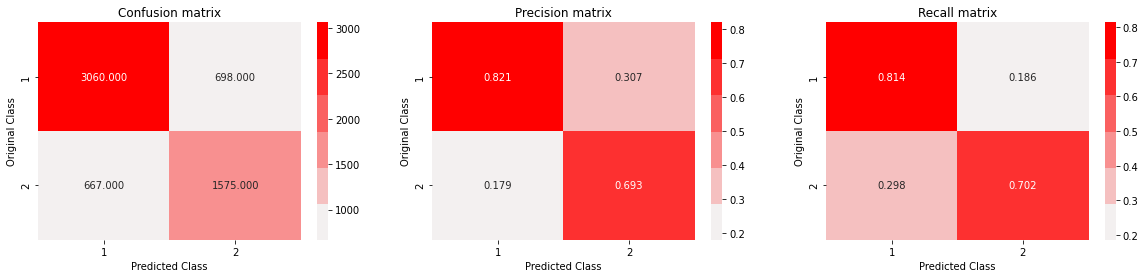

In [ ]:
# For ignoring ConvergenceWarning

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
    

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:

import sklearn.metrics as metrics
from sklearn.metrics import r2_score
score = metrics.r2_score(y_test, predicted_y)
print(score)

0.02794347972021871
